### Import necessary packages and the scikit-learn diabetes dataset

In [1]:
from sklearn.datasets import load_diabetes
import pandas as pd
import sys
sys.path.append('../')
from tabularmagic import TabularMagic
from tabularmagic.models import Linear, Tree, TreeEnsemble, SVM, MLP

diabetes_data = load_diabetes()
df = pd.DataFrame(data=diabetes_data.data, columns=diabetes_data.feature_names)
df['target'] = diabetes_data.target
display(df.head())

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930,141.0
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362,206.0
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641,135.0


### Create a TabularMagic object

In [2]:
tm = TabularMagic(df, test_size=0.2, random_state=42)

### Define a sequence of models

In [3]:
models = [
    # All models have default hyperparameter search methods built in.
    Linear(regularization_type=None, n_jobs=-1),
    Linear(regularization_type='l1', n_jobs=-1, random_state=42),
    Linear(regularization_type='l2', n_jobs=-1, random_state=42),
    Tree(n_jobs=-1),
    TreeEnsemble(ensemble_type='random_forest', n_jobs=-1),
    TreeEnsemble(ensemble_type='bagging', n_jobs=-1),
    TreeEnsemble(ensemble_type='gradient_boosting', n_jobs=-1),

    # You can manually set the nickname of a model
    SVM(kernel='rbf', nickname='SupportVectorMachine', n_jobs=-1),
    
    # You can specify the hypeparameter search method in an sklearn-like manner. 
    MLP(
        hyperparam_search_method='grid',
        hyperparam_grid_specification={
            'hidden_layer_sizes': [(50), (100), (50, 50)],
            'activation': ['relu'],
            'solver': ['adam'],
            'alpha': [0.0001, 0.001, 0.01],
            'learning_rate': ['constant', 'adaptive'],
            'max_iter': [200]
        }
    )
]

### Conduct a benchmarking exercise with the specified models

In [4]:
train_report, test_report = tm.comprehensive_model_benchmarking(
    X_vars = ['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6'],
    y_var = ['target'],
    models = models
)

Task 1 of 9. 	 Training Linear(None).


Task 2 of 9. 	 Training Linear(l1).
Task 3 of 9. 	 Training Linear(l2).
Task 4 of 9. 	 Training Tree.
Task 5 of 9. 	 Training TreeEnsemble(random_forest).
Task 6 of 9. 	 Training TreeEnsemble(bagging).
Task 7 of 9. 	 Training TreeEnsemble(gradient_boosting).
Task 8 of 9. 	 Training SupportVectorMachine.
Task 9 of 9. 	 Training MLP.


### View the testing goodness-of-fit statistics

In [5]:
display(test_report.fit_statistics)

,Linear(None),Linear(l1),Linear(l2),Tree,TreeEnsemble(random_forest),TreeEnsemble(bagging),TreeEnsemble(gradient_boosting),SupportVectorMachine,MLP
Statistic,,,,,,,,,
mse,2900.193628,2799.524281,2858.897821,3032.941952,2800.453132,2832.476503,3048.692302,2917.746346,3537.839671
mad,42.794095,42.806904,42.965389,44.185059,43.263641,43.619775,42.986817,43.021758,50.173543
pearsonr,0.677973,0.688156,0.680320,0.654633,0.688452,0.684018,0.661535,0.677247,0.610792
spearmanr,0.667263,0.673528,0.664360,0.644978,0.649233,0.653482,0.625516,0.661133,0.588750
r2,0.006905,-0.064047,-0.122735,-0.215993,-0.293737,-0.244812,0.041980,-0.193469,-2.995893
adjr2,-0.120415,-0.200463,-0.266675,-0.371889,-0.459601,-0.404404,-0.080844,-0.346477,-3.508187


### View the predicted vs true scatter plot of the ridge regression model on testing data.

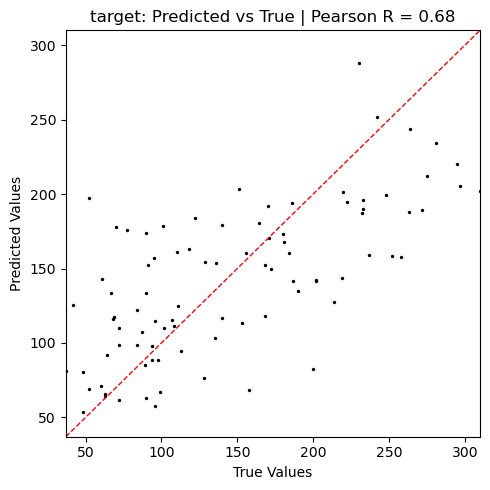

In [6]:
fig = test_report['Linear(l2)'].pred_vs_true_plot()

### View the MSE of the random forest model on testing data

In [7]:
print(test_report['TreeEnsemble(random_forest)'].scorer['mse'])

2800.4531318020986
